# Feedforward Nerual Networks

In this notebook, we show how neural networks described in chapter 5 of PRML can be implemented. 

Because the notation of the book has ambiguity, we first describe the formulation in detail, and then move to the corresponding code. 

In [1]:
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import time

%matplotlib inline
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

#to make this notebook's output stable across runs
np.random.seed(42)

# 1 Setting

Although we consider multiclass classification problem in our implementation, in Sections 1 and 2, we formulate the problem from broader perspectives, where we include regression, binary classification, and multiclass classification problems.

Let us define symbols as follows: 
* $N \in \mathbb{N}$ : data size, 
* $d \in \mathbb{N}$ : the dimension of input, 
* Denote input data by $x_0, x_1, \dots , x_{N-1} \in \mathbb{R}^{d}$. 
* For a regression problems, denote target data by $t_0, t_1, \dots, t_{N-1} \in \mathbb{R}$. 
* For a binary classification problem, denote target data by $t_0, t_1, \dots, t_{N-1} \in \{ 0, 1 \}$.
* For a multiclass classification problem, let $\mathcal{C} = \left\{ 0, 1, \dots, C-1 \right\}$ be the set of class labels, $t_0, t_1, \dots, t_{N-1} \in \left\{0,1\right\}^{C}$ be the 1-of-$C$ coding of target labels, i.e., if $n$-th label is $c$, $t_n$ is a vector with its $c$ th component being 1 and other components being zero. 

# 2 Theory

## 2.1 Model : the representation of neural networks

We consider $L$-layer feedforward neural networks (feedforward neural networks with $L-1$ hidden layers) such as one shown in the following figure: 
<img src="NNfig.png" alt="Drawing" style="width: 600px;"/>

For simplicity, we assume that there is no skip-layer connection, i.e.,  each element in a layer is connected only to elements in its adjacent layer. 

In this section, we write down the definition of functions representing a neural network. Specifically, we decompose the function representing the neural network, so that we can extract contributions of parameters from a specified layer, for calculation of gradient in the next section, where we want derivative with respect to parameters from each layer. 

### 2.1.1 The number of elements and the dimension

Let $n_l \in \mathbb{N}$ be the number of elements in the $l$-th layer. 
It follows that $n_0 = d$, and $n_L$ is the dimension of the output, which will be specified later.


### 2.1.2 Activation functions

Again for somplicity, we assume that activation functions for $l$-th layer with $l=1,2,\dots,L-1$ are all 
$h : \mathbb{R} \rightarrow \mathbb{R}$. $h$ can be, for example, logstic sigmoid function, tanh, ReLU and so on.
Also, we define $h^{(l)}$ by

$$
\begin{align}
    h^{(l)} : \mathbb{R}^{n_l} \rightarrow \mathbb{R}^{n_l}, \ \ 
    h^{(l)}(a) = (h(a_1), h(a_2), \dots, h(a_{n_l}))^T \ \in \mathbb{R}^{n_l}.
\end{align}
$$

Let us denote the activation function for the output layer by
$g : \mathbb{R}^{n_L} \rightarrow \mathbb{R}^{n_L}$. 

Concretely, $g$ can be chosen as below:
* For binary classification, $g$ can be logistic sigmoid function, and $n_L = 1$. 
* For multiclass classification, $g$ can be softmax function, and $n_L = C$, where $C$ is the number of class labels.
* For regression, $g$ can be an identity map, and $n_L = 1$.

### 2.1.3 The input and output of each layer

Let us define
* $z^{(l)} \in \mathbb{R}^{n_l}$ : the output from the $l$-th layer ($l=0,1, \dots, L-1$)
* $a^{(l)} \in \mathbb{R}^{n_{l+1}}$ : the input to the $(l+1)$-th layer ($l=0,1, \dots, L-1$)
* $y \in \mathbb{R}^{n_L}$ : the output of the final layer

Then, 
$$
\begin{align}
    z^{(l)} &= h^{(l)}(a^{(l-1)}) \ \ (l = 0,1, \dots, L-1) \\
    y &= g(a^{(L-1)})
\end{align}
$$
follows. 

Let us also define parameters as follows
* $w^{(l)}_{i,j}$ : the weight of $j$-th element of $l$-th layer on the $i$-th element of$(l+1)$-th layer. 
* $b^{(l)}_{i}$ : the bias of $i$-th element of $(l+1)$-th layer.

If we define 
$w^{(l)} = (w^{(l)}_{i,j})_{i,j}$ ($n_{l+1} \times n_{l}$ matrix) and  
$b^{(l)} = (b^{(l)}_{0}, b^{(l)}_{1}, \dots, b^{(l)}_{n_{l+1}-1})^T$, 
then we have

$$
\begin{align}
    a^{(l)} = w^{(l)} z^{(l)} + b^{(l)}
\end{align}
$$

For later convenience, we denote this affine mapping by 
$$
\begin{align}
    A^{(l)}_{\theta^{(l)}} : \mathbb{R}^{n_{l}} \rightarrow \mathbb{R}^{n_{l+1}}  , \ \ A^{(l)}_{\theta^{(l)} }(z) := w^{(l)}z + b^{(l)}
\end{align}, 
$$
where $\theta^{(l)} := (w^{(l)}, b^{(l)})$.

### 2.1.4 The whole network

Let a function $f_{\theta} : \mathbb{R}^{n_0} \rightarrow \mathbb{R}^{n_L}$ be the function that represents the whole neural network we defined above. 

From the definitions above, it can be written as 

$$
\begin{align}
    f_{\theta} = g \circ A^{(L-1)}_{\theta^{(L-1)}} \circ h^{(L-1)} \circ A^{(L-2)}_{\theta^{(L-2)}} \circ \cdots 
        A^{(l+1)}_{\theta^{(l+1)}} \circ h^{(l+1)} \circ A^{(l)}_{\theta^{(l)}} \circ h^{(l)} \circ A^{(l-1)}_{\theta^{(l-1)}} 
        \circ \cdots \circ h^{(1)} \circ A^{(0)}_{\theta^{(0)}} . 
\end{align}
$$


If we focus on parameters $\theta^{(l)}$, we can decompose the function as 
$$
\begin{align}
    f_{\theta} = F^{(l)} \circ A^{(l)}_{\theta^{(l)}}  \circ Z^{(l)} 
    \ \ (l = 0, \dots, L-1), 
\end{align}
$$

where

$$
\begin{align}
    F^{(l)} &:= g \circ A^{(L-1)}_{\theta^{(L-1)}} \circ h^{(L-1)} \circ A^{(L-2)}_{\theta^{(L-2)}} \circ \cdots 
        A^{(l+1)}_{\theta^{(l+1)}} \circ h^{(l+1)}  \ \ (l = 0,1, \dots, L-2) \\
    F^{(L-1)} &:= g \\
    Z^{(l)} &:= h^{(l)} \circ A^{(l-1)}_{\theta^{(l-1)}} \circ \cdots \circ h^{(1)} \circ A^{(0)}_{\theta^{(0)}}  \ \ (l = 1, \dots, L-1)\\
    Z^{(0)} &:= I
\end{align}
$$

Note that in the representation $f_{\theta} = F^{(l)} \circ A^{(l)}_{\theta^{(l)}}  \circ Z^{(l)}$, 
$A^{(l)}_{\theta^{(l)}}$ is the only part that contains $\theta^{(l)}$, 
which will simplify our calculation of gradients in the next section. 

## 2.2 Cost functions and its gradient

### 2.2.1 Cost functions

We assume that, in training the neural network, we minimize the following cost function
$$
\begin{align}
    E_{tot}(\theta) = \frac{1}{N} \sum_{n=1}^{N} E \left( f_{\theta}(x_n), t_n \right) + \frac{\lambda}{2N} \|\theta \|^2 , 
\end{align}
$$
where $\lambda$ is the regularization parameter, 
and $E$ is chosen appropriately depending on the problem: 
* For regression problem, $E$ can be $E(y,t) = \frac{1}{2} \| y - t \|^2$ and so on.
* For multiclass classification problem with $g$ being softmax functions, E can be $E(y,t) = -\sum_{k=0}^{d_{out}-1} t_k \log y_k$ (negative log likelihood).

### 2.2.2 Gradient 

Here, we calculate the gradient of the cost function with respect to parameters $w, b$. 
We consider the regularization term separately, and concentrate on the first term. 
We can treat each data point separately because this term has the form of summation over data.

The gradient for each term can be calculated as follows
($l = 0,1,\dots, L-1$, $i=0, 1, \dots, n_{l+1}-1$, $j=0, 1, \dots, n_{l}-1$):

$$
\begin{align}
    \delta^{(l)}_{i} &:= \sum_{k=0}^{n_L-1} \left. \frac{\partial E}{\partial y_k} \right|_{y=f_{\theta}(x)} \cdot 
        \left. \frac{\partial F^{(l)}_{k}}{\partial a^{(l)}_{i}} \right|_{a^{(l)}= (A^{(l)} \circ Z^{(l)})(x) } \\
    \frac{\partial}{\partial w^{(l)}_{i,j}} E \left( f_{\theta}(x), t \right) &= \delta^{(l)}_{i} Z^{(l)}_{j}(x) \\
    \frac{\partial}{\partial b^{(l)}_{i}} E \left( f_{\theta}(x), t \right) &= \delta^{(l)}_{i} 
\end{align}
$$
which can be derived straightforwardly from the definition of $f_{\theta}$ and the cost function given above.

Thus, to obtain the gradient, it is sufficient to calculate the quantities $\delta^{(l)}_{i}$. 
Here, $\delta^{(l)}_{i}$ represents how much the cost function changes when $a^{(l)}_{i}$, the input to the $i$-th element of $(l+1)$-th layer, changes slightly. We may denote $\delta^{(l)}_{i}$ ($i=0,1, \dots, n_{l+1}-1$) collectively by $\delta^{(l)}$.

In the next section, we discuss back propagation, which is an algorithm to calculate these quantities recursively. 


### 2.2.3 Back propagation

In back propagation procedure, we calculate $\delta^{(l)}_{i}$, begining from $l=L-1$, and all the way down to $l=0$. 

First, for $l=L-1$, we have $F^{(L-1)} = g$, and hence

$$
\begin{align}
    \delta^{(L-1)}_{i} = \sum_{k=0}^{n_L-1} \left. \frac{\partial E}{\partial y_k} \right|_{y=f_{\theta}(x)} \cdot 
        \left. \frac{\partial g_{k}}{\partial a^{(L-1)}_{i}} \right|_{a^{(L-1)}= (A^{(L-1)} \circ Z^{(L-1)})(x) }
\end{align}
$$

This can be easily calculated for various problems : 
* For least square regression, we have $E(y,t) = \frac{1}{2} \| y - t \|^2$, $g(a) = a$, and hence $\delta^{(L-1)}_{i} = (f_{\theta}(x) - t)_{i}$. 
* For multiclass classification with $E(y,t) = -\sum_{k=0}^{C-1} t_k \log y_k$, $g_k(a) = \frac{e^{a_k}}{\sum_{m} e^{a_m}}$, we obtain $\delta^{(L-1)}_{i} = (f_{\theta}(x) - t)_{i}$. 

Next, assume that we have obtained $\delta^{(l+1)}$ for a specific $l \leq L - 2$. 
We can derive a recursion equation where $\delta^{(l)}$ can be calculated from $\delta^{(l+1)}$ as follows:
$$
\begin{align}
    \delta^{(l)}_{i} = h'(a^{(l)}_{i}) \sum_{j=0}^{n_{l+2}-1} \delta^{(l+1)}_{j} w^{(l+1)}_{j,i}
\end{align}
$$
This equation can be derived easily by noting the relation $F^{(l)} = F^{(l+1)} \circ A^{(l+1)}_{\theta^{(l+1)}} \circ h^{(l+1)}$.

## 2.3 More on backpropagation

Having described the theory of back propagation in the previous section, we move a step forward to implement the idea.

### 2.3.1 Change of notations

From now on, to make the implementation simple, we treat weight $w$ and bias $b$ equally by defining 
$$
\begin{align}
    W^{(l)}_{i,j} = 
    \begin{cases}
        b^{(l)}_{i} & (j=0) \\
        w^{(l)}_{i,j-1} & (j = 1,2, \dots, n_{l})
    \end{cases}
    \ \ (i = 0,1, \dots,n_{l+1} -1 ) , 
\end{align}
$$
where $W^{(l)}$ is $n_{l+1} \times (n_{l}+1)$ matrix, and 
$$
\begin{align}
    \tilde{z}^{(l)}_{i} = 
    \begin{cases}
        1 & (i=0) \\
        z^{(l)}_{i-1} & (i = 1, \dots, n_l)
    \end{cases}
\end{align}
$$
With these notations, we have
$$
\begin{align}
    a^{(l)} &= W^{(l)} \tilde{z}^{(l)} \\
    \tilde{z}^{(l)} &= 
        \begin{pmatrix}
            1 \\
            z^{(l)}
        \end{pmatrix} \\
    \frac{\partial}{\partial W^{(l)}_{i,j}} E(f_{\theta}(x),t) &= \delta^{(l)}_{i} \tilde{z}^{(l)}_{j}
\end{align}
$$

### 2.3.2 Gradient for a single data point

For a data point $(x, t)$ we perform the following calculation : 

* Calculate $a, z$ for each layer (forward propagation) by 
$$
\begin{align}
    \tilde{z}^{(0)} &= (1,x^T)^T) \\
    a^{(l)} &= W^{(l)} \tilde{z}^{(l)}   \ \ (l=0, 1, \dots, L-1) ,\\
     \tilde{z}^{(l)} &=
        \begin{pmatrix}
            1 \\
            h^{(l)}(a^{(l-1)})
        \end{pmatrix}\ \ (l=1,\dots, L-1) \\
    y &= g(a^{(L-1)})
\end{align}
$$
* Calculate $\delta^{(L-1)}$. For examples described in section 3.3, we have
$$
\begin{align}
    \delta^{(L-1)}_i = (y - t)_i . 
\end{align}
$$
* Recursively calculate $\delta^{(l)}_{i}$ ($l= L-2, L-1, \dots, 1, 0$) by 
$$
\begin{align}
    \delta^{(l)}_{i} = h'(a^{(l)}_{i}) \sum_{j=0}^{n_{l+2}-1} \delta^{(l+1)}_{j} W^{(l+1)}_{j,i+1}
\end{align}
$$
where $i = 0,1, \dots, n_{l+1} - 1$
* Calculate the gradient using $\delta$
$$
\begin{align}
    \frac{\partial}{\partial W^{(l)}_{i,j}} E(f_{\theta}(x),t) = \delta^{(l)}_{i} \tilde{z}^{(l)}_{j}
\end{align}
$$

## 2.4 Optimization by gradient descent

To numerically minimize the cost function, here we use gradient descent method.

In gradient descent method, we iteratively update our variable in the direction of gradient, i.e., if we denote the function to be minimized by $f$ and its variable by $x$, then in the $n$-th step of iteration, we have
$$
\begin{align}
    x_{n+1} = x_n - \alpha \nabla f(x_n)
\end{align}
$$
where $\alpha > 0$ is learning rate, which should be specified by the user.

# 3 From math to code

Now, we translate our equations described above into codes. 
To perform computation efficiently, we utilize numpy array operation so that we do not have to code iteration over samples explicitly.


## 3.1 Overview 

Before delving into the detail, let me give an overview: 

* First, we list up some variables, and prepare some utility functions in Section 3.2.
* Next, we define functions performing forward propagation (`fprop`) and backward propagation (`bprop`) in Sections 3.3 and 3.4 respectively. Section 3.5 deals with the cost function and its gradient.
* Then, we will define a function performing minimization using gradient descent method in Section 3.6.
* Finally, in Section 3.7, we write `NeuralNet` class, which represents our neural network.

## 3.2 Variables

Let us define some variable as follows.

* `num_neurons` : ($L+1$,) array, where `num_neurons[l]` =  $n_{l}$ with $n_{0} = d$.
* `act_func` : activation function $h$.
* `act_func_deriv` : the derivative of the activation function, $h'$.
* `out_act_func` : the activation function for the output layer, $g$.
* `E` : a function representing the first term of the cost function, or more concretely $\frac{1}{N} \sum_{n=0}^{N-1}E(y_n, t_n)$
* `lam` : the regularization constant $\lambda$
* `W_matrices` : ($L$,) array, with `dtype='object'`, `W_matrices[l][i, j]` = $W^{(l)}_{i,j}$, 

The variables shown above mainly concerns the structure and the contents of neural networks.

Let us define some auxiliary matrices which depends on input data as follows:
* `X` : ($N, d_{in}$) array. The input data, where `X[n, i]` $= X_{n, i} :=(x_{n})_{i}$
* `C` : int, the number of categories we deal with.
* `y` : ($N$,) array. The label data. Each element of `y` should be one of `0,1, ... , C-1`.
* `T` : ($N, d_{out}$) array. The 1-of-C coding of the label data, where `T[n, i]` $= T_{n, i} := (t_{n})_{i}$
* `Y` : ($N, d_{out}$) array. `Y[n, i]` = $Y_{n, i} := $the $i$-th element of the output from the neural network given the input $x_{n}$.
* `A_matrices` : ($L$,) array, with `dtype='object'`, `A_matrices[l][n, i]` = $A^{(l)}_{n, i}$ := ($a^{(l)}_{i}$ for the $n$-th data point $x_n$). Note that $A^{(l)}$ is a $(N, n_{l+1})$ array.
* `Z_matrices` : ($L$,) array, with `dtype='object'`, `z_matrices[l][n, i]` = $Z^{(l)}_{n, i}$ := ($\tilde{z}^{(l)}_{i}$ for the $n$-th data point $x_n$). Note that $Z^{(l)}$ is a $(N, n_l+1)$ array.
* `D_matrices` : ($L$,) array, with `dtype='object'`, `D_matrices[l][n, i]` = $\Delta^{(l)}_{n,i} := (\delta^{(l)}_{i}$ for the $n$-th data point $(x_n, t_n)$). Note that $\Delta^{(l)}$ is a $(N, n_{l+1})$ array.


We included the subscript $n$ in each matrix, because we want to iterate over data points by taking advantage of numpy array operation (For detail, see the next section.).

Frist, we define a function which calculate 1-of-C encoding of the target variable.

In [2]:
def calcTmat(y, C):
    '''
    This function generates the matrix T from the training label y and the number of classes C
    
    Parameters
    ----------
    y : 1-D numpy array
        The elements of y should be integers in [0, C-1]
    C : int
        The number of classes
        
    Returns
    ----------
    T : (len(y), C) numpy array
        T[n, c] = 1 if y[n] == c else 0
    '''
    N = len(y)
    T = np.zeros((N, C))
    for c in range(C):
        T[:, c] = (y == c)
    return T


We defined `W_matrices` as a ($L$,) array, whose element `W_matrices[l]` is a $(n_{l+1}, n_l + 1)$ array.
However, for minimization process, it is easier to handle vector variables. 
Thus, for later convenience, here we define a function which transforms the 1-D array of arrays into a single vector and vice versa.

In [3]:
def reshape_vec2mat(vec, num_neurons):
    '''
    vec : 1-D numpy array, dtype float
        Vector, which we will convert into an array of matrices
    num_neurons : 1-D array, dtype int
        An array representing the structure of a neural network
    '''
    L = len(num_neurons) - 1
    matrices = np.zeros(L, dtype='object')
    ind = 0
    for l in range(L):
        mat_size = num_neurons[l+1] * (num_neurons[l] + 1)
        matrices[l] = np.reshape(vec[ind: ind + mat_size], ( num_neurons[l+1], num_neurons[l] + 1) )
        ind += mat_size        
    return matrices

def reshape_mat2vec(matrices, num_neurons):
    '''
    matrices : 1-D numpy array, dtype object
        An array of matrices (2-D numpy array), which we will convert into a flattened 1-D array of float.
    num_neurons : 1-D array, dtype int
        An array representing the structure of a neural network
    '''
    L = len(num_neurons) - 1
    vec = np.zeros( np.sum(num_neurons[1:]*(num_neurons[:L] + 1)) )
    ind = 0
    for l in range(L):
        mat_size = num_neurons[l+1]*(num_neurons[l] + 1)
        vec[ind:ind+mat_size] = np.reshape(matrices[l], mat_size)
        ind += mat_size
    return vec

## 3.3 forward propagation

In forward propagation, we calculate $A^{(l)}$ and $Z^{(l)}$ ($l=0,1,\dots, L-1$) by 

$$
\begin{align}
    Z^{(l)} &= \begin{cases}
        \left(\boldsymbol{1}_{N}, X \right) & (l=0) \\ 
        \left(\boldsymbol{1}_{N} , h\left(A^{(l-1)} \right)\right) & (l = 1, \dots, L-1) 
    \end{cases}\\
    A^{(l)} &= Z^{(l)} {W^{(l)}}^{T}
\end{align}
$$
and the final output $Y$ by 
$$
\begin{align}
    Y = g(A^{(L-1)}), 
\end{align}
$$
where $\boldsymbol{1}_N := (1, 1, \dots, 1)^T \in \mathbb{R}^{N}$, 
and we slightly abuse notations so that we regard $h$ and $g$ as acting elementwisely on $A^{(l)}$.

In [4]:
def fprop(W_matrices, act_func, out_act_func, X):
    '''
    This function performs forward propagation, and calculate input/output for each layer of a neural network.
    
    Parameters:
    ----------
    W_matrices : 1-D array, dtype='object'
        (L,) array, where W_matrices[l] corresponds to the parameters of l-th layer.
    act_func : callable
        activation function for hidden layers
    out_act_func : callable
        activation function for the final layer
    X : 2-D array
        (N,d) numpy array, with X[n, i] = i-th element of x_n
        
    Returns:
    ----------
    Z_matrices : 1-D array, dtype='object'
        Z_matrices[l] is 1-D array, which represents the output from the l-th layer.
    A_matrices : 1-D array, dtype='object'
        A_matrices[l] is 1-D array, which represents the input to the (l+1)-th layer.
    Y : 2-D array
        The final output of the neural network.
    '''
    L = len(W_matrices)
    N = len(X)
    Z_matrices = np.zeros(L, dtype='object')
    A_matrices = np.zeros(L, dtype='object')

    Z_matrices[0] = np.concatenate((np.ones((N, 1)), X), axis=1)
    A_matrices[0] = Z_matrices[0] @ (W_matrices[0].T)
    
    for l in range(1, L):
        Z_matrices[l] = np.concatenate((np.ones((N, 1)), act_func(A_matrices[l-1])), axis=1)
        A_matrices[l] = Z_matrices[l] @ (W_matrices[l].T)
    Y = out_act_func(A_matrices[L-1])
    
    return Z_matrices, A_matrices, Y

## 3.4 Backward propagation

In backward propagation, we calculate $\Delta^{(l)}$ as follows: 


* First, calculate $\Delta^{(L-1)}$. For examples described in section 3.3 we have $\Delta^{(L-1)} = Y - T$. However, note that in general  $\Delta^{(L-1)}$ may depend on $A^{(l)}$ and $Z^{(l)}$. In our implementation, `d_final_layer` takes care of the relation between $\Delta^{(L-1)}$ and $A^{(l)}, Z^{(l)}, Y$ and $T$.
* Recursively calculate $\Delta^{(l)}$ ($l= L-2, L-1, \dots, 1, 0$) by 
$$
\begin{align}
    \Delta^{(l)} = h'(A^{(l)}) \ast \left( \Delta^{(l+1)} (W^{(l+1)}\mathrm{[:, 1:]})\right), 
\end{align}
$$
where we again slightly abused the definition of $h$, $\ast$ stands for elementwise multiplication, and $(W^{(l+1)}\mathrm{[:, 1:]})$ stands for a matrix obtained by deleting the first column of $W^{(l)}$.

In [5]:
def bprop(W_matrices, act_func, act_func_deriv, out_act_func, Z_matrices, A_matrices, Y, T, d_final_layer):
    '''
    This function performs backward propagation and returns delta.
    
    Parameters
    ----------
    W_matrices : 1-D array, dtype='object'
        (L,) array, where W_matrices[l] corresponds to the parameters of l-th layer.
    act_func : callable
        activation function for hidden layers
    act_func_deriv : callable
        The derivative of act_func
    out_act_func : callable
        activation function for the final layer
    Z_matrices : 1-D array, dtype='object'
        Z_matrices[l] is 1-D array, which represents the output from the l-th layer.
    A_matrices : 1-D array, dtype='object'
        A_matrices[l] is 1-D array, which represents the input to the (l+1)-th layer.
    Y : 2-D array
        The final output of the neural network.
    T : 2-D array
        Array for the label data.
    d_final_layer : callable
        A function of Z_matrices, A_matrices, Y and T, which returns $delta^{(L-1)}$
    
    Returns
    ----------
    D_matrices : 1-D array
        D_matrices[l] is a 2-D array, where D_matrices[l][n, i] = $\Delta^{(l)}_{n, i}$

    '''
    L = len(W_matrices)
    D_matrices = np.zeros(L, dtype='object')
    
    D_matrices[L-1] = d_final_layer(Z_matrices, A_matrices, Y, T)
    for l in range(L-2, -1, -1):
        D_matrices[l] = act_func_deriv(A_matrices[l]) * ( D_matrices[l+1] @ W_matrices[l+1][:, 1:] )

    return D_matrices

## 3.5 Cost function and its gradient

Here we implement the function giving the value of the cost function and its gradient.

Recall that the cost function is given by
$$
\begin{align}
    E_{tot}(\theta) = \frac{1}{N} \sum_{n=1}^{N} E \left( f_{\theta}(x_n), t_n \right) + \frac{\lambda}{2N} \|\theta \|^2. 
\end{align}
$$

The gradient of the first term can be obtained by 
$$
\begin{align}
    \frac{\partial}{\partial W^{(l)}_{i,j}} \frac{1}{N}\sum_{n=0}^{N-1} E(f_{\theta}(x_n),t_n) 
    &= \frac{1}{N}\sum_{n=0}^{N-1} \Delta^{(l)}_{n,i} Z^{(l)}_{n,j} \\
    &= \frac{1}{N} \left( \Delta^{(l)T} Z^{(l)} \right)_{i,j}
\end{align}
$$

In [6]:
def cost_and_grad(W_matrices, X, T, act_func, act_func_deriv, out_act_func, E, d_final_layer, lam):
    '''
    This function performs backward propagation and returns delta.
    
    Parameters
    ----------
    W_matrices : 1-D array, dtype='object'
        (L,) array, where W_matrices[l] corresponds to the parameters of l-th layer.
    X : 2-D array
        (N,d) numpy array, with X[n, i] = i-th element of x_n    
    T : 2-D array
        Array for the label data.
    act_func : callable
        activation function for hidden layers
    act_func_deriv : callable
        The derivative of act_func
    out_act_func : callable
        activation function for the final layer
    E : callable
        A function representing the first term of the cost function
    d_final_layer : callable
        A function of Z_matrices, A_matrices, Y and T, which returns $delta^{(L-1)}$
    lam : float
        Regularization constant
        
    Returns
    ----------
    cost_val : float
        The value of the cost function
    grad_matrices : 1-D array, dtype object
        Array of 2-D matrices corresponding the gradient
    '''
    
    N = len(X)
    L = len(W_matrices)
    
    Z_matrices, A_matrices, Y = fprop(
        W_matrices=W_matrices, 
        act_func=act_func, 
        out_act_func=out_act_func, 
        X=X)
    
    cost_val = E(Y, T) + lam/(2*N)*( np.sum( np.linalg.norm(W)**2 for W in W_matrices ) )
    
    D_matrices = bprop(
        W_matrices=W_matrices, 
        act_func=act_func, 
        act_func_deriv=act_func_deriv, 
        out_act_func=out_act_func, 
        Z_matrices=Z_matrices, 
        A_matrices=A_matrices, 
        Y=Y, 
        T=T, 
        d_final_layer=d_final_layer)
    
    grad_matrices = np.zeros(L, dtype='object')
    for l in range(L):
        grad_matrices[l] = D_matrices[l].T @ Z_matrices[l] / N + lam/N * W_matrices[l]
    
    return cost_val, grad_matrices

## 3.6 Minimization by gradient descent

In gradient descent, we obtain an approximate optimal solution by the update
$$
\begin{align}
    x_{n+1} = x_n - \alpha \nabla f(x_n).
\end{align}
$$

Here, as to the stopping criterion, we examine the change of function value, and if it does not decrease more than the specified value `ftol`, we terminate the iteration.

In [7]:
def minimize_GD(func_and_grad, x0, alpha=0.01, maxiter=1e4, ftol=1e-5):
    '''
    This function minimizes the given function using gradient descent method
    
    Parameters
    ----------
    func_and_grad : callable
        A function which returns the tuple (value of function to be minimized (real-valued), gradient of the function)
    x0 : 1-D array
        Initial value of the variable
    alpha : float
        Learning rate
    maxiter : int
        Maximum number of iteration
    ftol : float
        The threshold for stopping criterion. If the change of the value of function is smaller than this value, the iteration stops.
    
    Returns
    ----------
    result : dictionary
        result['x'] ... variable, result['nit'] ... the number of iteration, result['func']...the value of the function, result['success']... whether the minimization is successful or not
    '''
    nit = 0
    x = x0
    val, grad = func_and_grad(x)
    while nit < maxiter:
        xold = x
        valold = val
        x = x - alpha*grad
        val, grad = func_and_grad(x)
        nit += 1
        if abs(val - valold) < ftol:
            break
    success = (nit < maxiter)
    return {'x': x, 'nit':nit, 'func':val, 'success':success}

## 3.7 Neural Network

Because we consider multiclass classification problem here, we use conventional choice of activation functions, where activation function for hidden layers are logistic sigmoid function, the activation function for the output layer is softmax, and the error function is cross-entropy.

In [8]:
def E(Y,T):
    N = len(Y)
    return -np.sum( T*np.log(Y) )/N

def softmax(x):
    x0 = np.max(x,axis=1)
    x0 = np.reshape(x0, (len(x0),1))
    tmp = np.sum(np.exp(x-x0),axis=1)
    return np.exp(x-x0)/np.reshape(tmp,(len(tmp),1))

def sigmoid(x):
    return 1.0/(1 + np.exp(-x))

def sigmoid_deriv(x):
    return np.exp(-x)/((1+np.exp(-x))**2)

def d_final_layer(Z, A, Y, T):
    return Y - T

With all the preparations, here we define our neural network, `NeuralNet` class.

In [9]:
class NeuralNet:
    def __init__(self, C, lam, num_neurons, act_func=sigmoid, act_func_deriv=sigmoid_deriv, out_act_func=softmax, E=E, d_final_layer=d_final_layer):
        self.C = C
        self.num_neurons = num_neurons
        self.L = len(num_neurons) - 1
        self.act_func = act_func
        self.act_func_deriv = act_func_deriv
        self.out_act_func = out_act_func
        self.E = E
        self.d_final_layer = d_final_layer
        self.lam = lam
        self.W_matrices = np.zeros(self.L,dtype='object') 
        
    def fit(self, X, y, ep=0.01, alpha=0.01, maxiter=1e4, ftol=1e-5, show_message=False): 
        '''
        Parameters
        ----------
        X : 2-D array
            (N,d) numpy array, with X[n, i] = i-th element of x_n    
        y : 1-D numpy array
            The elements of y should be integers in [0, C-1]
        ep : float
            The maximum value of the initial weight parameter, which will be used for random initialization
        alpha : float
            Learning rate
        maxiter : int
            Maximum number of iteration
        ftol : float
            The threshold for stopping criterion. If the change of the value of function is smaller than this value, the iteration stops.
        show_message : bool
            If True, the result of the optimization is shown.
        '''
        T = calcTmat(y, self.C)
        def cost_and_grad_vec(x):
            val, grad_mat = cost_and_grad(
                W_matrices=reshape_vec2mat(x, num_neurons=self.num_neurons),
                X=X, 
                T=T,
                act_func=self.act_func, 
                act_func_deriv=self.act_func_deriv,
                out_act_func=self.out_act_func,
                E=self.E,
                d_final_layer=self.d_final_layer,
                lam=self.lam
            )
            grad_vec = reshape_mat2vec(matrices=grad_mat, num_neurons=self.num_neurons)
            return val, grad_vec
        tht0 = 2*ep*(np.random.random(np.sum(self.num_neurons[1:]*(self.num_neurons[:self.L]+1))) - 0.5)
        time_start = time.time()
        result = minimize_GD(
            func_and_grad=cost_and_grad_vec,
            x0=tht0,
            alpha=alpha,
            maxiter=maxiter,
            ftol=ftol
        )
        time_end = time.time()
        if show_message:
            print(f"success : {result['success']}")
            print(f"nit : {result['nit']}")
            print(f"func value : {result['func']}")
            print(f"calcualtion time : {time_end - time_start}seconds")
        self.W_matrices=reshape_vec2mat(vec=result['x'], num_neurons=self.num_neurons)
    
    def predict_proba(self, X):
        '''
        Parameters
        ----------
        X : 2-D array
            (N,d) numpy array, with X[n, i] = i-th element of x_n
            
        Returns
        ----------
        Y : 2-D array
            (len(X), self.C) array, where Y[n, c] represents the probability that the n-th instance belongs to c-th class
        '''
        Z_matrices, A_matrices, Y = fprop(
            W_matrices=self.W_matrices, 
            act_func=self.act_func, 
            out_act_func=self.out_act_func, 
            X=X)
        return Y
    
    def predict(self, X):
        '''
        Parameters
        ----------
        X : 2-D array
            (N,d) numpy array, with X[n, i] = i-th element of x_n
            
        Returns
        ----------
        classes : 1-D numpy array
            (len(X), ) array, where classes[n] represents the predicted class to which the n-th instance belongs
        '''
        Y = self.predict_proba(X)
        return np.argmax(Y, axis=1) 

# 4 Experiment 

In [10]:
from sklearn import datasets
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

## 4.1 Gradient check

Because the implementation of the backward propagation is complicated, it is desirable to check whether the implementation is correct before we use the code. 

In this section, we compare the gradient obtained by the backward propagation and the gradient calculated from direct numerical differentiation. 

The numerical differentiation is obtained as follows
$$
\begin{align}
    \frac{\partial E_{tot} }{\partial W^{(l)}_{i,j}} \simeq 
        \frac{ E_{tot}(W^{(l)}_{i,j}+\varepsilon) - E_{tot}(W^{(l)}_{i,j}-\varepsilon) }{2\varepsilon}, 
\end{align}
$$
where we slightly abused the notation so that $E_{tot}(W^{(l)}_{i,j}\pm\varepsilon)$ means the value of the function, where all the elements, except for the $(l,i,j)$ element, of $W$ is fixed to $W^{(l')}_{i',j'}$, and the $(l,i,j)$ element is perturbed by $\varepsilon$.
The quantity $\varepsilon$ is assumed to be small, and the error is $\mathcal{O}(\varepsilon^2)$, 

In [11]:
def grad_check(nn, W_vec, X, T, ep):
    num_params = len(W_vec)
    W_matrices = reshape_vec2mat(W_vec, nn.num_neurons)
    cost, grad_mat_bp = cost_and_grad(W_matrices, X, T, act_func=nn.act_func, act_func_deriv=nn.act_func_deriv, out_act_func=nn.out_act_func, E=nn.E, d_final_layer=nn.d_final_layer, lam=nn.lam)
    grad_vec_bp = reshape_mat2vec(grad_mat_bp, nn.num_neurons)
    
    grad_vec_num = np.zeros(num_params)
    for cnt in range(num_params):
        W_p = np.copy(W_vec)
        W_m = np.copy(W_vec)
        W_p[cnt] += ep
        W_m[cnt] -= ep
        cost_p, grad_p = cost_and_grad(reshape_vec2mat(W_p, nn.num_neurons), X, T, act_func=nn.act_func, act_func_deriv=nn.act_func_deriv, out_act_func=nn.out_act_func, E=nn.E, d_final_layer=nn.d_final_layer, lam=nn.lam)
        cost_m, grad_m = cost_and_grad(reshape_vec2mat(W_m, nn.num_neurons), X, T, act_func=nn.act_func, act_func_deriv=nn.act_func_deriv, out_act_func=nn.out_act_func, E=nn.E, d_final_layer=nn.d_final_layer, lam=nn.lam)
        grad_vec_num[cnt] = (cost_p - cost_m )/(2*ep)
    return np.linalg.norm(grad_vec_bp - grad_vec_num), grad_vec_bp, grad_vec_num

Using the code, we perform gradient check for a small neural network.

In [12]:
num_neurons = np.array([4, 3, 2])

L = len(num_neurons) - 1
dim_W = np.sum(num_neurons[1:] * (num_neurons[:L]+1))
nn = NeuralNet(C=3, lam=1.0, num_neurons=num_neurons)
W_vec = np.arange(0.0, dim_W, 1)
X = np.reshape(np.arange(0.0, 2*num_neurons[0], 1.0), (2, num_neurons[0]))
T = np.array([[1.0,0],[0,1]])
error, grad_vec_bp, grad_vec_num = grad_check(nn, W_vec, X, T, ep=0.0001)

print(np.linalg.norm(grad_vec_bp)**2)
print(np.linalg.norm(grad_vec_num)**2)
print(error)

958.749997375419
958.7499973563445
1.641231604721956e-09


We can see that the difference between the two gradients, where one is obtained by backward propagation and the other by numerical differentiation, is sufficiently small.

## 4.2 Toy data 

Having checked the validity of our implementation, here we apply our code to simple toy data.

In [13]:
def get_meshgrid(x, y, nx, ny, margin=0.1):
    x_min, x_max = (1 + margin) * x.min() - margin * x.max(), (1 + margin) * x.max() - margin * x.min()
    y_min, y_max = (1 + margin) * y.min() - margin * y.max(), (1 + margin) * y.max() - margin * y.min()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    return xx, yy

def plot_result(ax, clf, xx, yy, X, t):
    Z = (clf.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.7)
    ax.scatter(X[:,0], X[:,1], c=t, edgecolor='k')

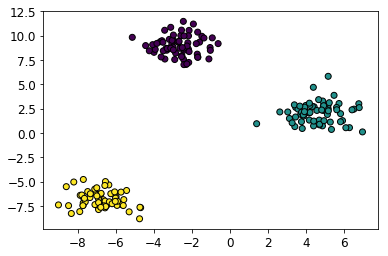

In [14]:
X, t = datasets.make_blobs(n_samples=200, n_features=2, centers=3, random_state=42)
plt.scatter(X[:,0], X[:,1], c=t, edgecolor='k')
plt.show()

xx, yy = get_meshgrid(X[:, 0], X[:, 1], nx=100, ny=100, margin=0.1)

Here we construct our neural network with $L=2$ and $n_0 = 2, n_1 = 2, n_2 = 3$. Note that $n_0$ and $n_L$ is fixed once we fix the input dimension and the class numbers.

success : True
nit : 1493
func value : 0.14345242871226377
calcualtion time : 0.7380423545837402seconds


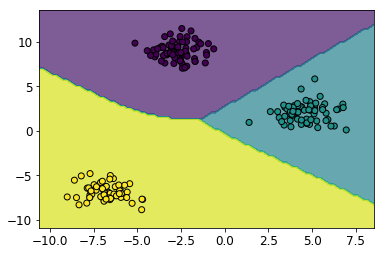

In [15]:
clf = NeuralNet(C=3, lam=0.5, num_neurons=np.array([2, 2, 3]))
clf.fit(X, t, show_message=True, ep=0.1, alpha=0.1, ftol=1e-5)
ax = plt.subplot(111)
plot_result(ax, clf, xx, yy, X, t)

## 4.3 Hand-written digits

In [16]:
digits = datasets.load_digits()
dat_train, dat_test, label_train, label_test = train_test_split(digits.data, digits.target, test_size=0.25)

print(f"Training data : {len(dat_train)}")
print(f"Test data : {len(dat_test)}")
print(f"Input dimension : {dat_train.shape[1]}")

Training data : 1347
Test data : 450
Input dimension : 64


In [17]:
def show_result_digit(clf):
    label_test_pred = clf.predict(dat_test)
    print(f"train accuracy score: {accuracy_score(label_train, clf.predict(dat_train))}")
    print(f"test accuracy score: {accuracy_score(label_test, label_test_pred)}")

Again, we try out $L=2$ neural network. We have to choose $n_0=64, n_2 = 10$. The choice of $n_1$ is arbitrary, but here we try $n_1 = 35$.

In [18]:
num_neurons = np.array([64,35,10])
nn_mnist = NeuralNet(C=10, lam=0.5, num_neurons=num_neurons)
nn_mnist.fit(dat_train, label_train, show_message=True, ep=0.01, alpha=0.1, ftol=1e-5)
show_result_digit(nn_mnist)

success : True
nit : 2205
func value : 0.052883086715949365
calcualtion time : 11.59360384941101seconds
train accuracy score: 0.9985152190051967
test accuracy score: 0.98
